<a href="https://colab.research.google.com/github/ParthikB/Vohoo-PyTorch/blob/master/cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


# PREPROCESSING

In [90]:
import os
import cv2
from tqdm import tqdm
import numpy as np

                                  # VARIABLES #
DATA_EXTRACTED = True
DATA_CREATED   = True
DATA_BALANCED  = True
CLIP           = 1680  #Clip every feature lenght at CLIP is data is not balanced.
#____________________________________________________________________________________#
                              
                              # DOWNLOADING DATA #
PATH = '/content/drive/My Drive/Colab Notebooks/pyTorch/data/'
os.chdir(PATH)

os.environ['KAGGLE_USERNAME'] = "parthikb" # username from the json file 
os.environ['KAGGLE_KEY'] = "079b1e8e73bd390b39218acc15c82b09" # key from the json file
!kaggle datasets download -d chetankv/dogs-cats-images
#____________________________________________________________________________________#
                             
                              # EXTRACTING DATA #
if not DATA_EXTRACTED:
  from zipfile import ZipFile

  file_name = 'dogs-cats-images.zip'

  with ZipFile(file_name, 'r') as zip:
    print('Initiating Extraction...')
    zip.extractall()
    print('Done!')
#____________________________________________________________________________________#
                               
                                # MOVING DATA #
# PATH += 'dog vs cat/dataset'
# os.chdir(PATH)

# To move the dataset folders...

# import shutil
# shutil.move(PATH+'/training_set', '/content/drive/My Drive/Colab Notebooks/pyTorch/data/dog vs cat/')
# shutil.move(PATH+'/test_set', '/content/drive/My Drive/Colab Notebooks/pyTorch/data/dog vs cat/')
#____________________________________________________________________________________#
                          
                           # CREATING TRAINING SET #
PATH = '/content/drive/My Drive/Colab Notebooks/pyTorch/data/dog vs cat/training_set'
os.chdir(PATH)

class DogsVSCats:
  IMG_SIZE     = 50
  CATS         = os.path.join(PATH, 'cats') 
  DOGS         = os.path.join(PATH, 'dogs')
  labels       = {CATS:0, DOGS:1}
  training_data = []
  cat_count, dog_count = 0, 0

  def createTrainingData(self):
    try:
      for label in self.labels:
        os.chdir(label)
        data = os.listdir()
        for image in tqdm(data):
          img = os.path.join(label, image)
          img = cv2.imread(img, 0)

          one_hot = np.eye(len(self.labels))[self.labels[label]]
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          
          self.training_data.append([np.array(img), one_hot])
          
          if label == self.CATS:
            self.cat_count += 1
          else:
            self.dog_count += 1
    except Exception as e:
      print(e)

    np.random.shuffle(self.training_data)
    np.save('/content/drive/My Drive/Colab Notebooks/pyTorch/data/dog vs cat/training_data.npy', self.training_data)
    print('Cats : ', self.cat_count)
    print('Dogs : ', self.dog_count)
    
if not DATA_CREATED:
  print('Creating Training set...')
  dogsVScats = DogsVSCats()
  dogsVScats.createTrainingData()

#____________________________________________________________________________________#
                              
                              # BALANCING TRAINING SET #
def balance_training_data(training_data):  
  print('Balancing Training set...')
  cat_counter, dog_counter = 0, 0
  balanced_training_data = []

  for data in tqdm(training_data):
    if data[1][0] == 1 and cat_counter < CLIP: #if cat
      cat_counter += 1
      balanced_training_data.append(data)
    elif data[1][1] == 1 and dog_counter < CLIP: #if dog
      dog_counter += 1
      balanced_training_data.append(data)

  return balanced_training_data

dogs-cats-images.zip: Skipping, found more recently modified local copy (use --force to force download)


# Creating Network

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    x = self.convs(x)

    # x = torch.flatten(x)
    # print(x.shape)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, 512)
    self.fc2   = nn.Linear(512, 2)

    # x = self.forward(x)

  def convs(self, x):

    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self.flatten)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=1)
    return x


# Modifying Training Data

In [93]:
# Test split percentage
TEST_PERCENTAGE = 0.2

training_data = np.load('/content/drive/My Drive/Colab Notebooks/pyTorch/data/dog vs cat/training_data.npy', allow_pickle=True)
training_data = balance_training_data(training_data)

x = torch.tensor([data[0] for data in training_data]).view(-1, 50, 50)
x = x/255.0
y = torch.tensor([data[1] for data in training_data])

test_size = int(x.shape[0] * TEST_PERCENTAGE)

x_train, y_train = x[:-test_size], y[:-test_size]
x_test,  y_test  = x[-test_size:].to(device), y[-test_size:].to(device)

100%|██████████| 5680/5680 [00:00<00:00, 464579.69it/s]

Balancing Training set...


# Running Network

In [0]:
import torch.optim as optim
import matplotlib.pyplot as plt

In [0]:
def train(net, EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):

  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
  loss_func = nn.MSELoss()
  loss_log  = []

  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(x_train), BATCH_SIZE)):
        x_batch = x_train[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        y_batch = y_train[i:i+BATCH_SIZE].to(device)

        net.zero_grad()
        output = net(x_batch)
        loss = loss_func(output, y_batch.float())
        loss.backward()
        optimizer.step()
    loss_log.append(loss)
    # print(f"Epoch : {epoch} || Loss : {loss}")

  return loss_log

In [0]:
# plt.plot(loss_log)

## Test Accuracy

In [0]:
def test(net):
  correct = 0
  total   = 0

  with torch.no_grad():
    for i in tqdm(range(len(x_test))):
      real_class = torch.argmax(y_test[i])
      pred_class = torch.argmax(net(x_test[i].view(-1, 1, 50, 50)))

      total += 1
      if real_class == pred_class:
        correct += 1

  accuracy = (correct/total)*100
  print()
  print(f'Accuracy : {round(accuracy, 2)} %')

In [102]:
net = Net().to(device)

loss_log = train(net, EPOCHS=3, BATCH_SIZE=16)


100%|██████████| 168/168 [00:01<00:00, 126.55it/s]


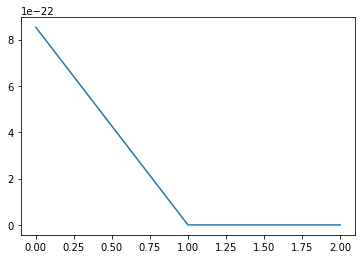

In [103]:
plt.plot(loss_log)

In [107]:
test(net)

100%|██████████| 672/672 [00:00<00:00, 849.41it/s]


Accuracy : 100.0 %


In [105]:
loss_log

[tensor(8.5319e-22, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0., device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0., device='cuda:0', grad_fn=<MseLossBackward>)]